In [23]:
%matplotlib inline

In [2]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import eugene as eu

Global seed set to 13


In [3]:
import shap
import seqexplainer

In [4]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["pdf.fonttype"] = 42

In [5]:
import sys
sys.path.append("/cellar/users/aklie/projects/use_cases/king20/")
from utils import *

In [6]:
dataset_dir = "/cellar/users/aklie/data/eugene/"

# Synthetic sequences

In [7]:
eu.settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/SYN"
eu.settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/SYN"
eu.settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/SYN"

In [8]:
sdata = eu.dl.read_h5sd(os.path.join(dataset_dir, "king20", "SYN.h5sd"))
sdata

SeqData object with = 624 seqs
seqs = (624,)
names = (624,)
rev_seqs = None
ohe_seqs = (624, 4, 80)
ohe_rev_seqs = None
seqs_annot: 'CRE_normalized_mean', 'Class', 'E_presence', 'Element_id_simplified', 'K_presence', 'O_presence', 'Position.1_E', 'Position.1_K', 'Position.1_O', 'Position.1_S', 'Position.2_E', 'Position.2_K', 'Position.2_O', 'Position.2_S', 'Position.3_E', 'Position.3_K', 'Position.3_O', 'Position.3_S', 'Position.4_E', 'Position.4_K', 'Position.4_O', 'Position.4_S', 'S_presence', 'log_CRE_normalized_mean', 'seq_len', 'train_val'
pos_annot: None
seqsm: None
uns: None

## Independent and position RF regressor

In [16]:
model_type = "random_forest"
model_features = "independent_position"

In [18]:
import pickle
rf = pickle.load(open(os.path.join(eu.settings.logging_dir, model_type, model_features, "model.pkl"), "rb"))

In [33]:
from utils import _impurity_decrease

In [34]:
feature_cols = sdata.seqs_annot.columns[sdata.seqs_annot.columns.str.contains("presence|Position")]

In [56]:
def _impurity_decrease(
    model, 
    feature_names,
    plot=True,
    prefix="",
    suffix="",
    copy=False
):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    descending_ord = np.argsort(importances)
    importances = importances[descending_ord]
    std = std[descending_ord]
    names = feature_names[descending_ord]
    forest_importances = pd.DataFrame(data={"importances": importances, "std": std}, index=names)
    if plot:
        fig, ax = plt.subplots()
        forest_importances["importances"].plot.barh(yerr=std, ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")
        plt.show()
    return forest_importances

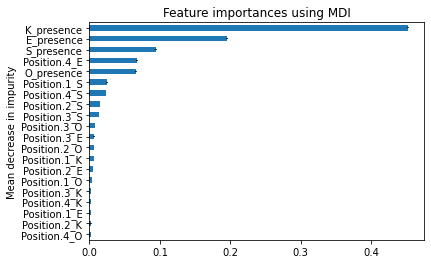

In [57]:
importances = _impurity_decrease(rf, feature_cols, plot=True)

In [110]:
X = sdata.seqsm[model_features]
explainer = shap.TreeExplainer(rf)

In [111]:
feature_cols = sdata.seqs_annot.columns[sdata.seqs_annot.columns.str.contains("presence|Position")]
sdata.seqsm[model_features] = sdata.seqs_annot[feature_cols].values
pred = rf.predict(sdata.seqsm[model_features])
shap_values = explainer.shap_values(X)

In [115]:
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

9.103828801926284e-15

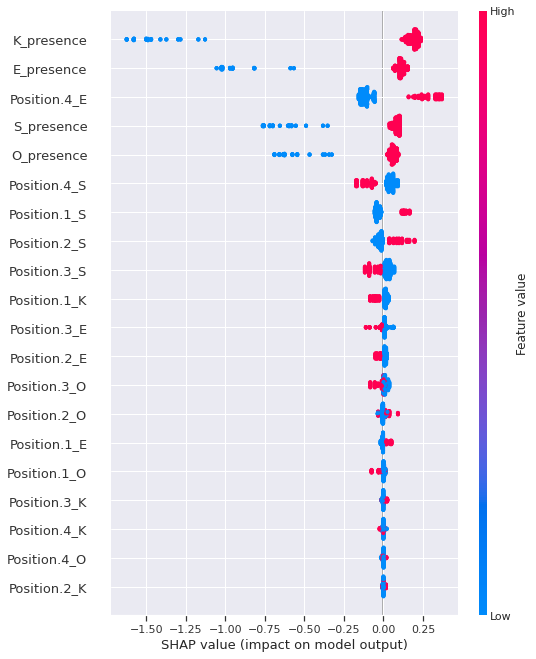

In [116]:
shap.summary_plot(shap_values, sdata.seqsm[model_features], feature_names=feature_cols)

In [124]:
shap_values = explainer(X)

In [124]:
shap.plots.beeswarm(shap_values)

In [117]:
shap_interaction_values = explainer.shap_interaction_values(X)

In [118]:
# ensure the SHAP interaction values sum to the marginal predictions
np.abs(shap_interaction_values.sum((1,2)) + explainer.expected_value - pred).max()

9.325873406851315e-15

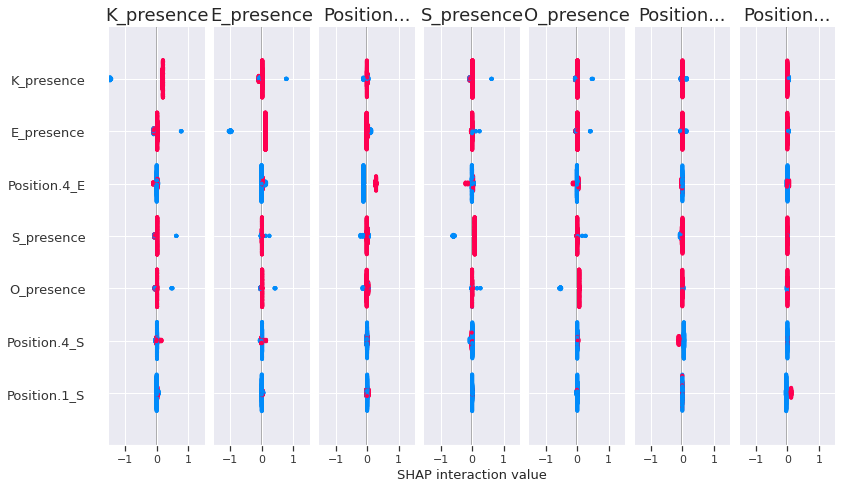

In [127]:
shap.summary_plot(shap_interaction_values, X, feature_names=feature_cols)

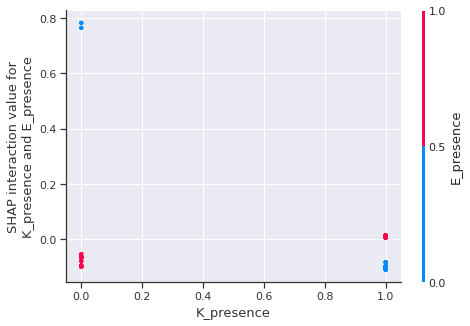

In [132]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("K_presence", "E_presence"),
    shap_interaction_values, 
    X,
    feature_cols
)

In [120]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction_values).mean(0)
df = pd.DataFrame(mean_shap, index=feature_cols, columns=feature_cols)

In [121]:
# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

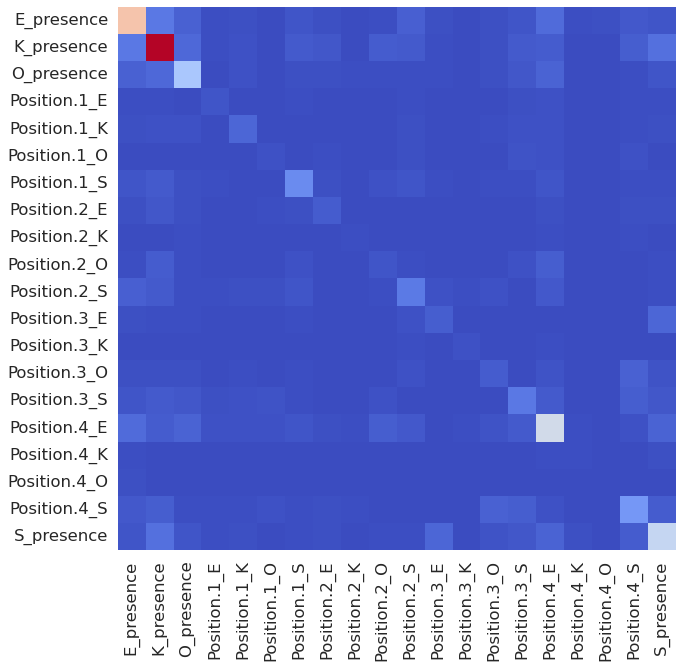

In [122]:
# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df, cmap='coolwarm', annot=False, fmt='.3g', cbar=False)
plt.yticks(rotation=0) 
plt.show()

## CNN feature attribution

In [9]:
model_type = "cnn"
model_features = "ohe"

In [10]:
best_cnn = eu.models.CNN.load_from_checkpoint(
    glob.glob(os.path.join(eu.settings.logging_dir, model_type, model_features, "checkpoints", "*"))[0]
)

In [11]:
import torch

In [12]:
explains = seqexplainer.attribute_on_batch(
    best_cnn,
    inputs=torch.Tensor(sdata.ohe_seqs),
    method="GradientShap",
    reference_type="dinuc_shuffle"
)

Computing feature attributions on batches of size 128:   0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
# Randomly select 10 sequences with random seed
np.random.seed(0)
sort = np.random.choice(sdata.n_obs, 10)
X = sdata.ohe_seqs[sort]

In [18]:
explains -= np.mean(explains, axis=1, keepdims=True)
explains = explains[sort]*X

In [21]:
import tfomics

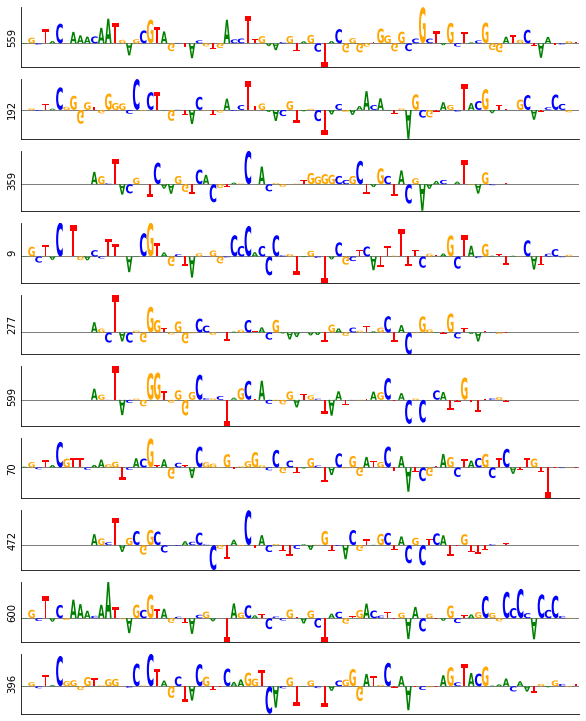

In [24]:
num_plot = 10
fig = plt.figure(figsize=(num_plot,13))
for i in range(num_plot):
    ax = plt.subplot(num_plot, 1, i+1)
    saliency_df = pd.DataFrame(explains[i].transpose([1,0]), columns=["A","C","G","T"])
    saliency_df.index.name = "pos"
    tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    plt.ylabel(sort[i])
plt.show()

In [13]:
pos_patterns, neg_patterns = seqexplainer.modisco(
    sdata.ohe_seqs,
    explains.numpy(),
    output_dir=os.path.join(eu.settings.output_dir, model_type, model_features, "modisco"),
    min_metacluster_size=10,
    flank_size=2,
    sliding_window_size=6,
    target_seqlet_fdr=0.1
)

Output directory already exists: /cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/SYN/cnn/ohe/modisco


In [159]:
pos_patterns, neg_patterns

([<modiscolite.core.SeqletSet at 0x15533a81d2d0>,
 [])

In [160]:
seqexplainer.modisco_report(
    os.path.join(eu.settings.output_dir, model_type, model_features, "modisco", "modisco.h5"),
    meme_db_file="/cellar/users/aklie/data/shared/meme/motif_databases/HUMAN/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme",
    output_dir=os.path.join(eu.settings.output_dir, model_type, model_features, "modisco", "report"),
    top_n_matches=3,
    trim_min_length=5
)

Output directory already exists: /cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/SYN/cnn/ohe/modisco/report


Errors from MEME text parser:
The PSPM of motif 1 has probabilities which don't sum to 1 on row 26.
The PSPM of motif 1 has probabilities which don't sum to 1 on row 26.
FATAL: Requested motif number 1  was not found in file '/tmp/tmp6xberj3g'.



EmptyDataError: No columns to parse from file

# Genomic sequences

In [25]:
eu.settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN"
eu.settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN"
eu.settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN"

## gkmSVM

In [26]:
model_type = "gkm_svm"
model_features = "kmer"

In [27]:
sdata = eu.dl.read_h5sd(os.path.join(dataset_dir, "king20", "GEN_gkm_svm.h5sd"))
sdata

SeqData object with = 202 seqs
seqs = (202,)
names = (202,)
rev_seqs = None
ohe_seqs = (202, 4, 82)
ohe_rev_seqs = None
seqs_annot: 'CRE_norm_expression_WT_all', 'Class', 'log_CRE_norm_expression_WT_all', 'range', 'seq_len', 'top_25', 'train_val'
pos_annot: None
seqsm: None
uns: None

In [28]:
eu.external.gkm_svm.explain(
    model="GEN",
    sdata=sdata,
    file_names=["GEN.fasta"],
    data_dir=os.path.join(dataset_dir, "king20", "fasta"),
    log_dir=os.path.join(eu.settings.logging_dir, "gkm_svm", "clf"),
    out_dir=os.path.join(eu.settings.logging_dir, "gkm_svm", "clf"),
    file_label="GEN"
)

/cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN/gkm_svm/clf/GEN.model.txt
Running gkmexplain on /cellar/users/aklie/data/eugene/king20/fasta/GEN.fasta with model /cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN/gkm_svm/clf/GEN.model.txt and mode 0
gkmexplain /cellar/users/aklie/data/eugene/king20/fasta/GEN.fasta /cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN/gkm_svm/clf/GEN.model.txt /cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN/gkm_svm/clf/GEN_explanations.txt -m 0 -T 4 -v 2
Predictions saved to /cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN/gkm_svm/clf/GEN_explanations.txt


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: could not broadcast input array from shape (4,81) into shape (4,)

In [29]:
#read in the importance scores
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("/cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN/gkm_svm/clf/GEN_explanations.txt")
]

In [30]:
# Clean up
impscores_pd = np.array([np.vstack((score, np.array([0, 0, 0, 0]))) if score.shape[0] == 81 else score for score in impscores])
impscores_final = impscores_pd.transpose(0, 2, 1)

In [214]:
pos_patterns, neg_patterns = seqexplainer.modisco(
    sdata.ohe_seqs,
    impscores_final,
    output_dir=os.path.join(eu.settings.output_dir, model_type, model_features, "modisco"),
)

Output directory already exists: /cellar/users/aklie/projects/ML4GLand/use_cases/king20/models/GEN/gkm_svm/kmer/modisco


In [219]:
sdata.ohe_seqs.shape, impscores_final.shape

((202, 4, 82), (202, 4, 82))

In [31]:
# Randomly select 10 sequences with random seed
np.random.seed(0)
sort = np.random.choice(sdata.n_obs, 10)
X = sdata.ohe_seqs[sort]

In [32]:
import tfomics

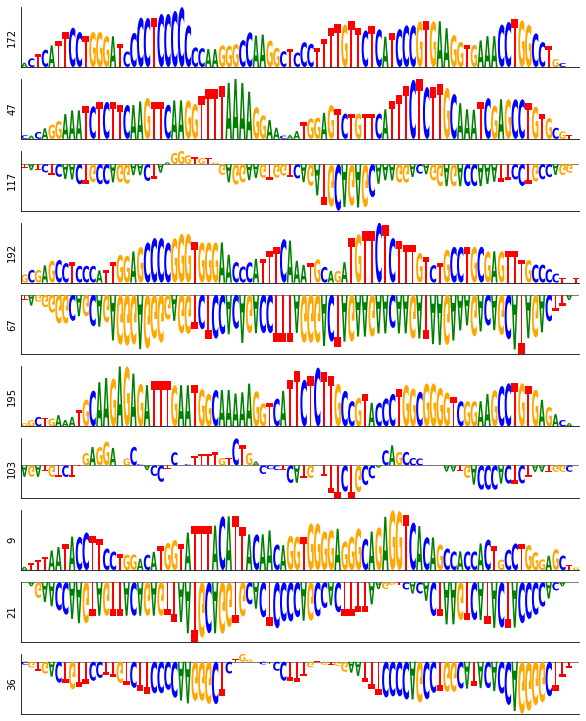

In [33]:
num_plot = 10
fig = plt.figure(figsize=(num_plot,13))
for i in range(num_plot):
    ax = plt.subplot(num_plot, 1, i+1)
    saliency_df = pd.DataFrame(impscores_final[sort[i]].transpose([1,0]), columns=["A","C","G","T"])
    saliency_df.index.name = "pos"
    tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    plt.ylabel(sort[i])

# DONE!

---